# Fmrate prediction

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import pandas as pd
import copy
import sys

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

sys.path.append('../')

from src.load_data import train_val_test_split

## Split data

In [2]:
data_df = pd.read_csv("../data/fmrate_dataset.csv")

In [3]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,...,rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,...,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,...,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,...,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,...,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,...,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,...,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,...,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,...,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,...,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [4]:
X = data_df.drop(columns=[f"rate[{i}]" for i in range(12)])
y = data_df[[f"rate[{i}]" for i in range(12)]]

In [5]:
X

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,is_orbit_up,altitude,sun,sun_spot,B_r,B_theta,B_phi
0,1470.0615,340.447390,34.386083,39.438089,-36.972051,33.6,69.831172,41.997769,1.483525e+09,8323.0,True,376.131102,19.0,72.4,-39193.080835,-20979.807253,1729.812864
1,1530.0690,344.948899,34.294665,40.152989,-39.919769,33.7,74.831447,42.486682,1.483526e+09,7893.0,True,375.738921,19.0,72.4,-40101.703258,-20889.235541,1549.857910
2,1590.0730,349.471306,34.021657,40.929578,-42.707255,33.8,79.894200,42.732372,1.483526e+09,8616.0,True,375.379107,19.0,72.4,-40806.117699,-20916.030570,1278.673806
3,1650.0795,353.998464,33.578979,41.795244,-45.338568,33.9,84.978480,42.730839,1.483526e+09,7961.0,False,375.063898,19.0,72.4,-41264.432292,-21067.198077,915.193701
4,1710.0840,358.501904,32.952299,42.798457,-47.833584,34.0,90.041732,42.481912,1.483526e+09,7857.0,False,374.784932,19.0,72.4,-41434.644115,-21347.676257,468.751810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64677,0.0000,70.353786,-29.267651,100.477836,57.059095,34.3,102.504047,-39.787169,1.489744e+09,19174.0,False,388.099321,5.0,70.5,47355.553109,-13418.374197,-4356.912817
64678,0.0000,74.590641,-30.153896,98.939578,57.476146,34.3,107.186486,-40.836773,1.489745e+09,21385.0,False,387.793437,5.0,70.5,48500.835937,-13218.504481,-3548.625486
64679,0.0000,78.749244,-30.790904,97.410511,57.831276,34.4,111.848502,-41.645589,1.489745e+09,22211.0,False,387.483253,5.0,70.5,49390.650877,-13125.342373,-2692.293649
64680,0.0000,83.137941,-31.353051,95.710760,58.025618,34.4,116.784951,-42.257397,1.489745e+09,23759.0,False,387.169976,5.0,70.5,50058.811556,-13141.213561,-1747.318052


In [6]:
y

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,56941.760321,1264.897761,9.175346,2.398795,0.000000,144902.177530,45712.324384,13845.953080,8356.903924,2438.513754,239474.841087,11744.694832
1,58123.694878,1296.198799,12.970488,0.977676,0.000000,153318.962241,48581.165475,14829.628152,8883.639889,2635.849803,253521.561985,12586.337166
2,58244.963030,1278.068894,22.955236,6.997275,1.440506,153940.468185,48497.795501,14516.429778,8760.980672,2490.574534,253464.050166,12447.241383
3,58325.603325,1293.320262,10.679009,0.000000,0.000000,153332.226326,48214.601357,14549.504555,8738.605590,2533.338163,253057.586337,12516.820358
4,57655.444528,1226.298473,10.958631,1.675759,0.000000,152311.547934,48175.919461,14699.423072,8731.916784,2473.908613,249121.718756,12395.476760
...,...,...,...,...,...,...,...,...,...,...,...,...
64677,166768.282730,3383.497463,20.845726,0.000000,0.000000,421381.161376,91254.976413,18187.144117,10166.549068,2520.873146,675029.015069,17152.212729
64678,201208.113638,3954.093915,15.407485,0.498087,0.000000,493352.601640,91960.388522,18408.719222,10437.676092,2687.357262,787895.241321,17259.848070
64679,168499.665785,3143.015693,19.850554,3.139644,0.000000,381079.484260,80642.260970,19433.904554,10932.724402,2747.667543,648988.657261,17762.022693
64680,157398.392828,2854.361729,19.554150,1.672301,0.000000,339358.361808,78711.053376,20140.309630,11353.850287,2851.749516,594285.018883,18096.580711


In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y,
                                                                      val_size=0.2,
                                                                      test_size=0.2,
                                                                      random_state=42,
                                                                      shuffle=True)

In [8]:
[el.shape for el in [X_train, X_val, X_test, y_train, y_val, y_test]]

[(38808, 17), (12937, 17), (12937, 17), (38808, 12), (12937, 12), (12937, 12)]

**We're not allowed to use the test set to make any decision !!**

## Preprocessing

- https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling
- https://youtu.be/juEOOQntrd0

## Basic Fully Connected NN

In [9]:
estimator = MLPRegressor(hidden_layer_sizes=[100, 100], random_state=42, max_iter=500)
pipe = make_pipeline(StandardScaler(), estimator)

In [10]:
pipe.fit(X_train, y_train)

C:\Users\steph\.virtualenvs\POLAR-background-prediction-cyL85rzf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[100, 100], max_iter=500,
                              random_state=42))])

In [11]:
pred = pipe.predict(X_val)
pd.DataFrame(pred)

,0,1,2,3,4,5,6,7,8,9,10,11
0,61722.165874,1575.604284,16.892557,2.500565,5.482233,157165.290726,47834.919964,12974.579572,7503.128590,2117.913727,265489.235222,11437.434765
1,98304.104206,3126.897082,31.423961,7.973380,0.851115,279256.823462,74245.205838,19725.425184,11867.850411,3703.793971,426041.175096,17392.054885
2,54880.497636,1363.364759,17.095278,1.378307,1.753087,146037.914566,43204.046136,12145.147857,7110.476989,2034.679725,237042.201853,10548.886392
3,46609.888841,1147.828048,12.215211,3.485758,-0.553678,132734.847640,32606.565238,8126.945945,4809.019153,1448.698614,199541.395652,7306.610249
4,57108.902349,1523.716167,20.359116,4.325988,0.810115,165790.910910,44332.055233,11766.198286,6888.640332,1948.811859,249951.166259,10147.482523
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,98207.653483,-358.161137,26.444415,7.342040,1.068538,191231.586596,52130.434413,16798.945921,9520.442322,2368.025392,400565.600457,14967.360431
12933,42036.786315,1348.906945,14.524067,3.717144,0.885490,118804.562248,33423.865833,8804.639983,5292.187300,1606.410666,176669.802570,7626.767547
12934,49454.629116,1299.605647,12.960286,2.865127,0.053559,137335.675613,35384.368090,9092.601947,5366.395172,1585.349632,205101.441092,8012.598732
12935,47013.284110,1295.040962,20.445856,4.428458,1.176005,140967.758911,38681.339670,12348.490451,7562.010888,2323.649458,209977.246034,10325.917381


In [12]:
y_val

,rate[0],rate[1],rate[2],rate[3],rate[4],rate[5],rate[6],rate[7],rate[8],rate[9],rate[10],rate[11]
0,63714.487231,1223.650552,9.334296,1.105197,0.000000,151092.152316,44955.312493,12165.963757,7023.230979,1912.205616,260762.629681,10760.596886
1,67711.925025,1607.662435,16.864431,1.100319,0.000000,183076.529341,62626.598177,18316.663814,10639.850081,2858.243524,297125.316997,15933.804070
2,55774.134068,1198.781719,12.524857,2.399933,0.000000,147956.343629,43724.464878,12372.556492,7251.458890,2012.472125,239765.939522,10568.263605
3,47059.098109,1065.865044,8.746947,1.429096,0.000000,135892.020199,33874.406058,8553.290799,4992.267112,1403.965876,205017.112127,7774.789680
4,54282.384588,1134.889051,11.642484,2.674487,0.000000,151723.024742,43410.263887,12553.080129,7342.095191,1950.565334,232745.662310,10490.552228
...,...,...,...,...,...,...,...,...,...,...,...,...
12932,116918.264377,1886.088149,20.081289,3.532154,0.000000,199967.189814,62288.267914,16758.780412,9594.698500,2463.608980,415697.808169,15501.675469
12933,39994.685070,952.063362,3.009176,1.754939,0.000000,121876.827317,30528.564993,8202.976469,4871.864938,1372.358619,178714.044216,6995.930446
12934,47145.563931,1016.822680,9.931920,0.954286,0.000000,136680.763003,34549.799903,9396.764113,5637.066540,1684.266364,203431.800433,8156.340244
12935,40088.039053,1044.381334,11.241683,1.739397,0.000000,135010.976846,41569.797539,13708.903615,8488.094385,2680.193162,190127.748876,11045.473511


### Visualization

Let's only look at `rate[0]`

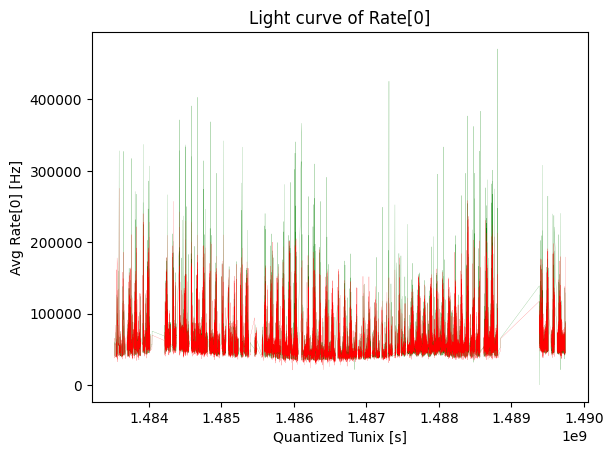

In [13]:
argsort = np.argsort(X_val["unix_time"])[::-1]
sorted_time_val = X_val["unix_time"][argsort]
sorted_y_val_r0 = y_val.loc[:, "rate[0]"][argsort]
sorted_val_r0 = pred[:, 0][argsort]

plt.plot(sorted_time_val, sorted_y_val_r0, '-g', linewidth=0.1)
plt.plot(sorted_time_val, sorted_val_r0, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]")
plt.show()

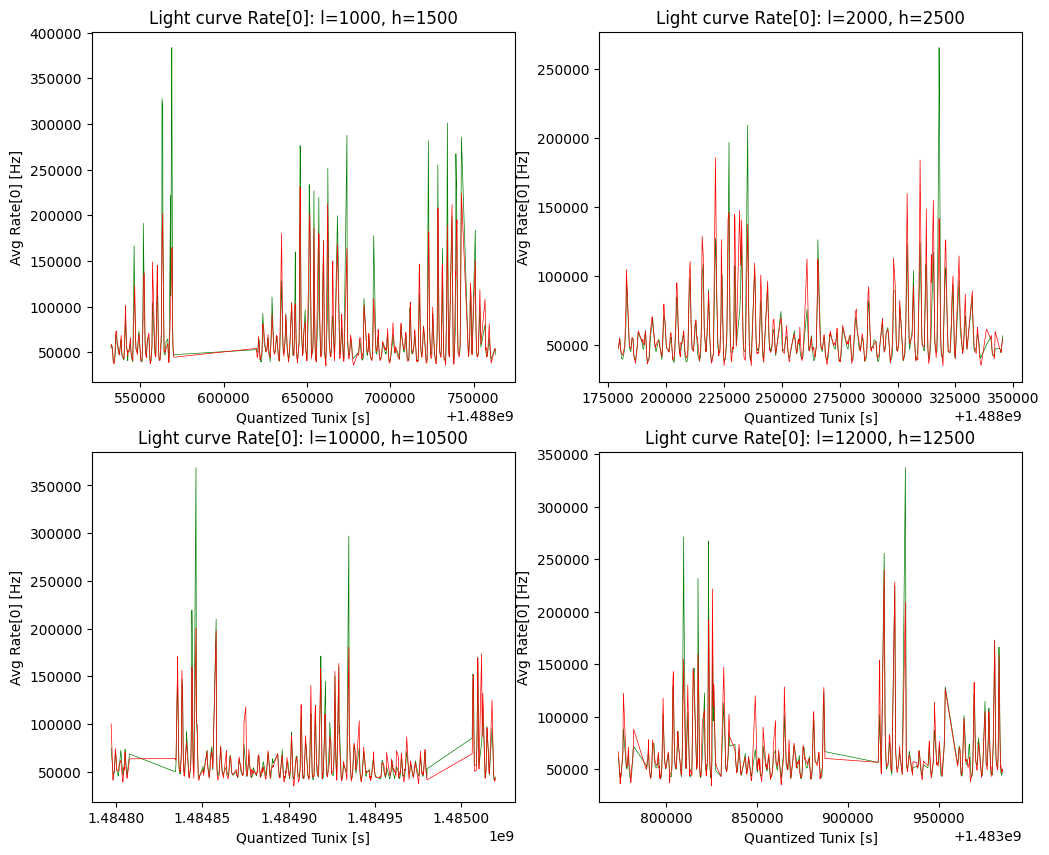

In [14]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1500), (2000, 2500),
                                   (10000, 10500), (12000, 12500)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

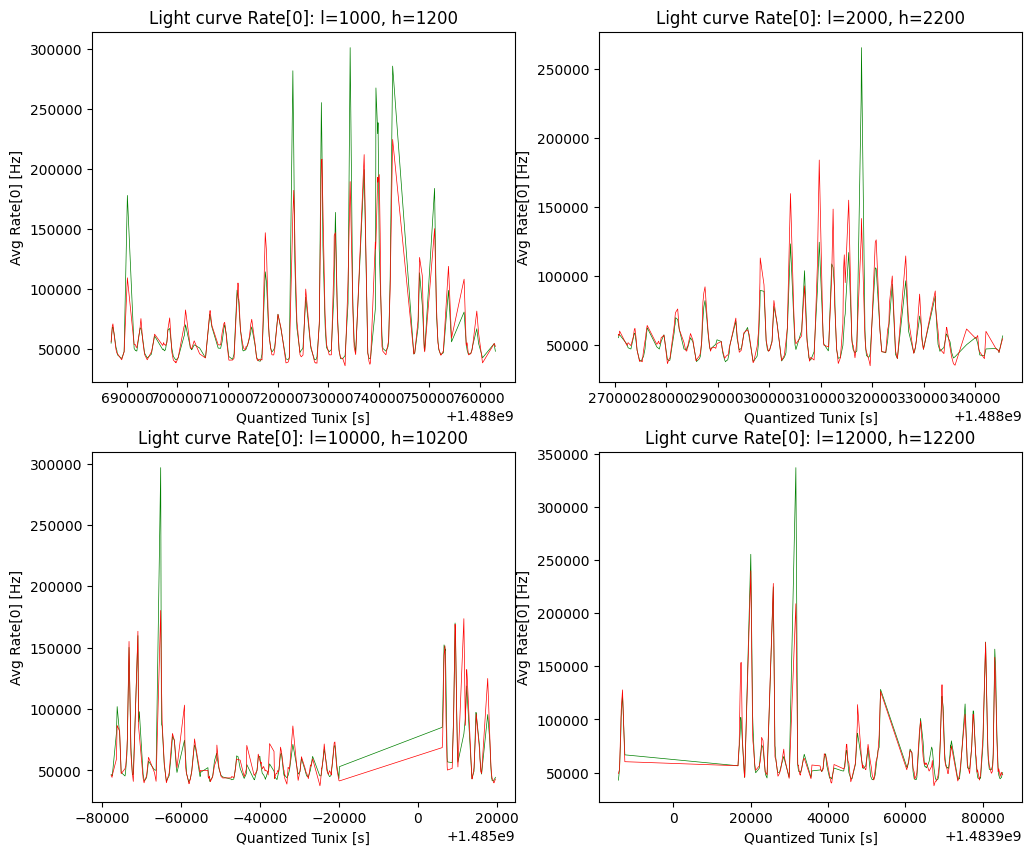

In [15]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1200), (2000, 2200),
                                   (10000, 10200), (12000, 12200)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

In [16]:
fitted_mlp = pipe["mlpregressor"]

In [17]:
np.sqrt(fitted_mlp.loss_), np.std(sorted_y_val_r0)

(17217.579839123126, 33781.365942676144)

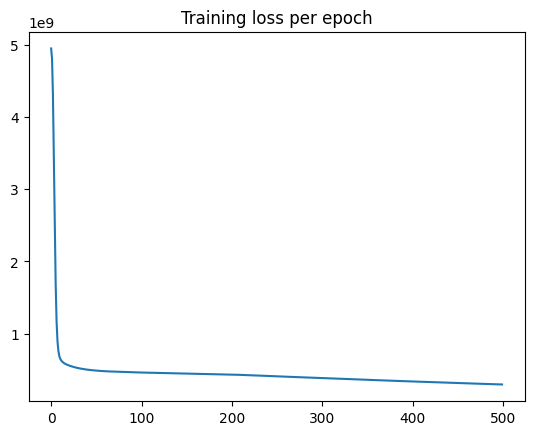

In [18]:
plt.plot(fitted_mlp.loss_curve_)
plt.title("Training loss per epoch")
plt.show()

The loss is still quiet huge

In [19]:
fitted_mlp.coefs_

[array([[-1.0414192 ,  1.63449213,  0.38315498, ..., -1.2016973 ,
         -4.18787951, -3.82496087],
        [-2.3288004 ,  3.95560409,  2.59231325, ...,  0.24092072,
          2.04854281,  2.90329965],
        [ 0.857761  , -2.12040446, -0.71143538, ..., -2.14920094,
         -0.51910837, -0.02817653],
        ...,
        [-4.64263971, -1.96300588, -2.9239664 , ..., -4.21266446,
         -3.12046038, -3.66798058],
        [ 6.32167775,  2.19342357,  2.44892581, ..., -8.5403259 ,
          4.15830085,  4.08804012],
        [-0.03832624, -0.17332427, -0.3033124 , ..., -5.41374999,
          1.91599625,  1.3820545 ]]),
 array([[  3.93461051,   1.34467765,   0.44097945, ...,   3.65055084,
           2.94189368,   1.30348428],
        [  3.72452766,  -2.23128424,  -1.98470756, ...,   3.52671796,
           0.25684612,   0.03193294],
        [  3.1940909 ,  -1.21254162,   0.09862088, ...,   3.30449555,
          -4.95507261,   1.42591607],
        ...,
        [  5.20476628, -11.87091677,

**TODO: try compare it with linear regression only using `fe_cosmic`. Also show validation loss for each epoch !**

### Residual plot
**Warning: we're gonna use the whole dataset, careful about data leakage**

In [20]:
# predict using the whole X.. just to observe the residuals
pred_X = pipe.predict(X)

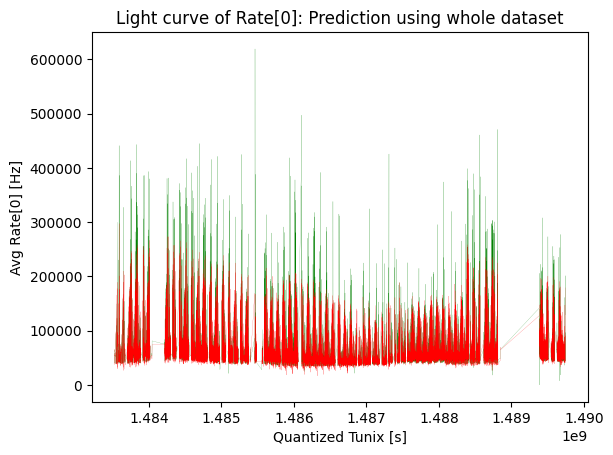

In [21]:
def plot_pred(X, y, pred_X, show=True, title="Light curve of Rate[0]: Prediction using whole dataset"):
    plt.plot(X["unix_time"], y.loc[:, "rate[0]"], '-g', linewidth=0.1)
    plt.plot(X["unix_time"], pred_X[:, 0], '-r', linewidth=0.1)
    plt.xlabel("Quantized Tunix [s]")
    plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    plt.title(title)
    if show: plt.show()

plot_pred(X, y, pred_X)

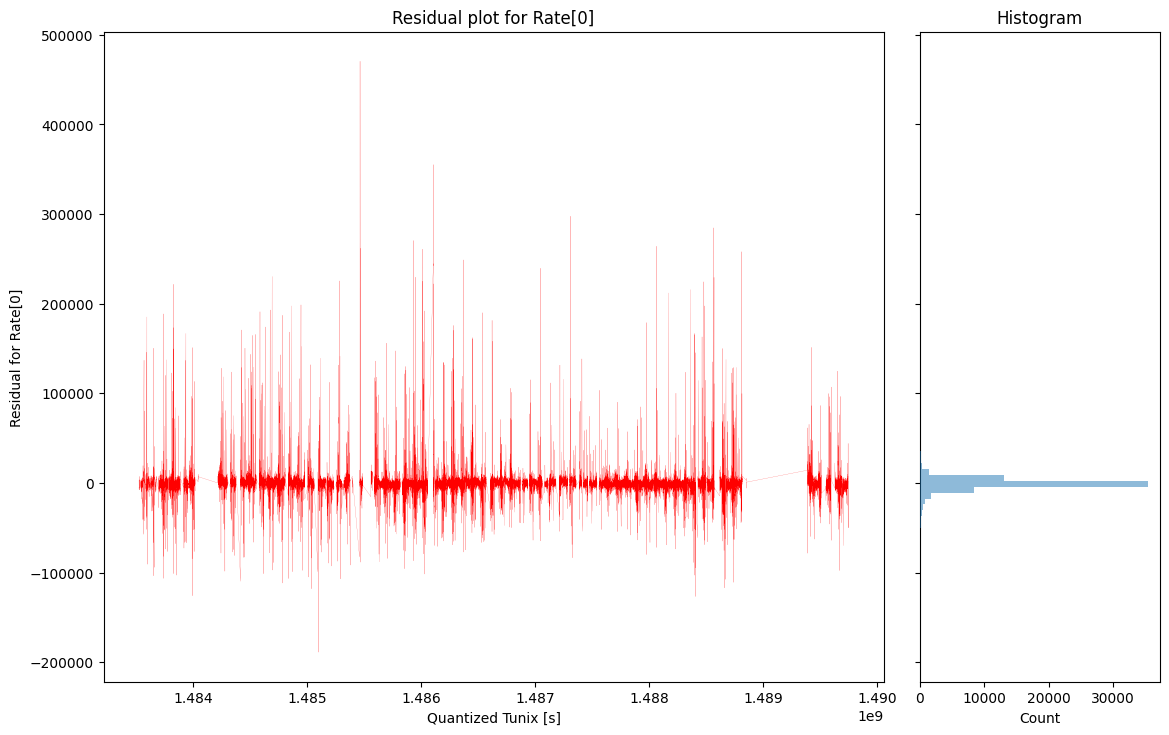

In [22]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03
rect_residuals = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes(rect_residuals)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax.plot(X["unix_time"], y.loc[:, "rate[0]"]-pred_X[:, 0], '-r', linewidth=0.1)
ax.set_xlabel("Quantized Tunix [s]")
ax.set_ylabel("Residual for Rate[0]")  # Nb. photons per second (averaged over each bin)
ax.set_title("Residual plot for Rate[0]")



ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_title("Histogram")
ax_histy.set_xlabel("Count")


_ = ax_histy.hist(y.loc[:, "rate[0]"]-pred_X[:, 0], bins=100, orientation='horizontal', alpha=0.5, zorder=np.inf)


plt.show()

**TODO: try compare it with linear regression only using `fe_cosmic`. Also show validation loss for each epoch !**

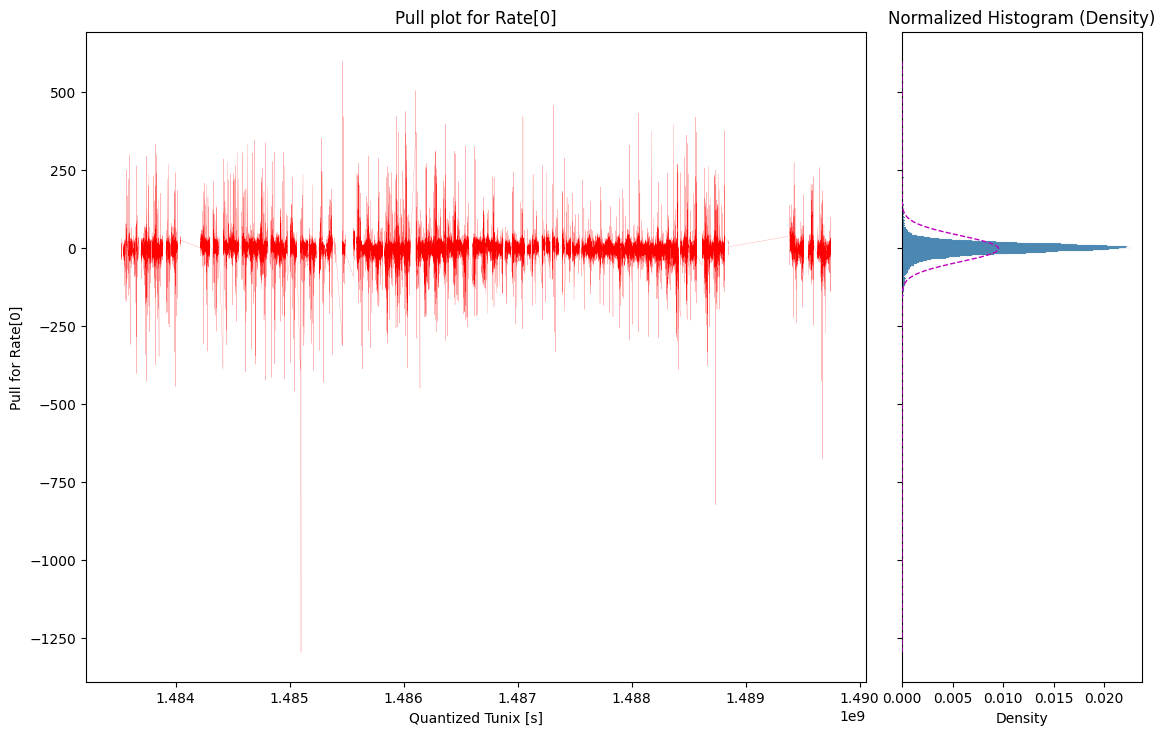

In [23]:
import seaborn as sns

def plot_pull(X, y, pred_X, show=True, 
              title="Pull plot for Rate[0]", 
              title_hist="Normalized Histogram (Density)"):
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    spacing = 0.03
    rect_residuals = [left, bottom, width, height]
    rect_histy = [left + width + spacing, bottom, 0.2, height]

    fig = plt.figure(figsize=(12, 10))
    # fig = plt.gcf()
    ax = fig.add_axes(rect_residuals)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)

    tmp = (y.loc[:, "rate[0]"]-pred_X[:, 0])/np.sqrt(y.loc[:, "rate[0]"])
    mask = ~np.isclose(y.loc[:, "rate[0]"], 0)

    ax.plot(X["unix_time"][mask], tmp[mask], '-r', linewidth=0.1)
    ax.set_xlabel("Quantized Tunix [s]")
    ax.set_ylabel("Pull for Rate[0]")  # Nb. photons per second  (averaged over each bin)
    ax.set_title(title)



    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.set_title(title_hist)


    # _ = ax_histy.hist(tmp[mask], bins=100, orientation='horizontal', alpha=0.5, zorder=np.inf)
    _ = sns.histplot(data=tmp[mask].to_frame("rate[0]"),
                     y="rate[0]",
                     stat="density",
                     ax=ax_histy)
    mean = np.mean(tmp[mask])
    std = np.std(tmp[mask])
    xs = np.linspace(tmp[mask].min(), tmp[mask].max(), 255)
    f = lambda x: 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mean)**2/(2*std**2))
    _ = ax_histy.plot(f(xs), xs, zorder=np.inf, color="m", linewidth=1, linestyle="--")

    if show: plt.show()

plot_pull(X, y, pred_X)

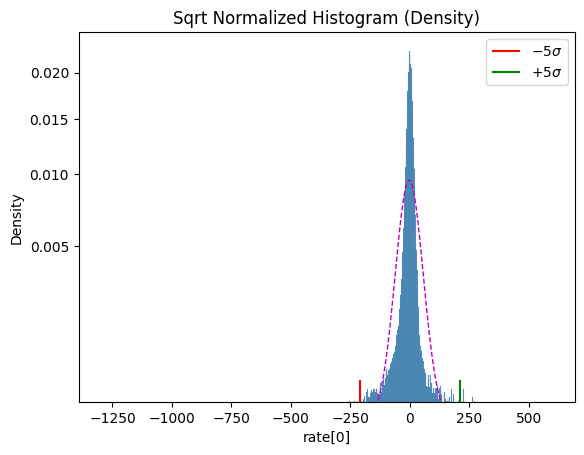

In [24]:
from matplotlib.scale import FuncScale


def plot(data, mean, std, transform="sqrt", show=True, title="Normalized Histogram (Density)"):
    f = lambda x, mean, std: 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mean)**2/(2*std**2))
    
    plt.plot()
    _ = sns.histplot(data=data,
                     x="rate[0]",
                     stat="density",
                     ax=plt.gca())
    
    xs = np.linspace(data.min(), data.max(), 255)
    plt.plot(xs, f(xs, mean, std), zorder=np.inf, color="m", linewidth=1, linestyle="--")
    plt.vlines(-5*std, 0, f(xs, mean, std).max()/36, 'r', label=r"$-5\sigma$")
    plt.vlines(5*std, 0, f(xs, mean, std).max()/36, 'g', label=r"$+5\sigma$")
    plt.legend()
    if transform == "sqrt":
        plt.yscale(FuncScale(0, (lambda x: np.sqrt(x), lambda x: np.power(x, 2))))
        if title is not None: plt.title("Sqrt Normalized Histogram (Density)")
    else:
        if title is not None: plt.title(title)
    if show: plt.show()

tmp = (y.loc[:, "rate[0]"]-pred_X[:, 0])/np.sqrt(y.loc[:, "rate[0]"])
mask = ~np.isclose(y.loc[:, "rate[0]"], 0)
mean = np.mean(tmp[mask])
std = np.std(tmp[mask])
    
plot(tmp[mask].to_frame("rate[0]"), mean, std)

In [25]:
5*std

208.3542850147382

In [26]:
def find_std(data):
    low = -np.inf
    high = np.inf
    prev_std = np.inf
    std = np.std(data)
    mean = np.mean(data)
    
    while ~np.isclose(prev_std, std):
        # Update interval
        low = -3*std + mean
        high = 3*std + mean
        
        prev_std = std
        std = np.std(data[(data>low) & (data<high)])
        print(mean, std, low, high)
    return mean, std

In [27]:
new_mean, new_std = find_std(tmp[mask])

-2.96538217208528 25.80783838728125 -127.97795318092821 122.04718883675764
-2.96538217208528 20.98138317983708 -80.38889733392904 74.45813298975847
-2.96538217208528 19.352515499478923 -65.90953171159653 59.97876736742597
-2.96538217208528 18.757371489675595 -61.02292867052204 55.09216432635149
-2.96538217208528 18.533223878860422 -59.23749664111207 53.30673229694151
-2.96538217208528 18.448194385399194 -58.56505380866654 52.634289464495986
-2.96538217208528 18.418177332770128 -58.309965328282864 52.37920098411231
-2.96538217208528 18.40577092627102 -58.21991417039566 52.289149826225106
-2.96538217208528 18.403316489141943 -58.182694950898345 52.25193060672779
-2.96538217208528 18.402145604000268 -58.17533163951111 52.24456729534055
-2.96538217208528 18.402145604000268 -58.17181898408608 52.241054639915525


In [28]:
std, new_std

(41.67085700294764, 18.402145604000268)

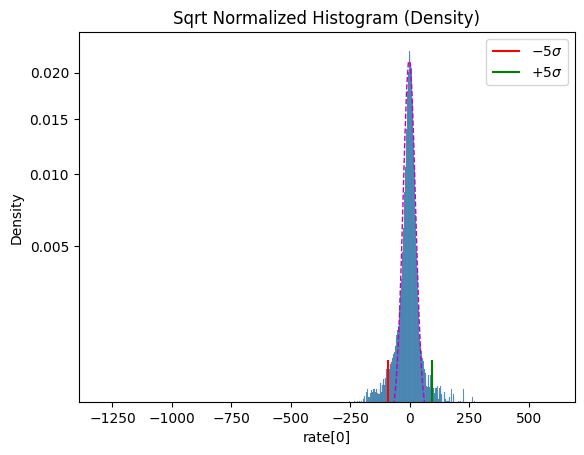

In [29]:
plot(tmp[mask].to_frame("rate[0]"), mean, new_std)
plt.show()

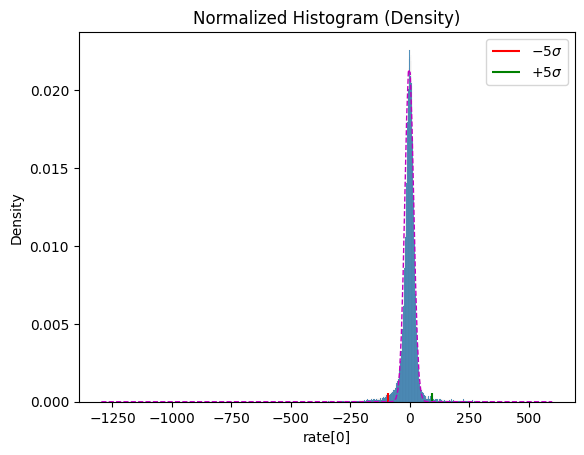

In [30]:
plot(tmp[mask].to_frame("rate[0]"), mean, new_std, transform=None)
plt.show()

**Weights and biases logs**

In [31]:
# import wandb
# from wandb.sklearn import plot_learning_curve

# model = pipe
# model_params = model.get_params()

# # Wandb:
# wandb.init(project='POLAR-background-prediction', config=model_params)
# wandb.config.update({"val_size": 0.2,
#                      "test_size": 0.2,
#                      "val_len": X_val.shape[0],
#                      "test_len": X_test.shape[0],
#                      "train_len": X_train.shape[0],
#                      "random_state": 42,
#                      "shuffle_data": True})

# # plot_learning_curve(model, X_train, y_train)

# wandb.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stephane-nguyen. Use `wandb login --relogin` to force relogin


<IPython.core.display.Javascript object>


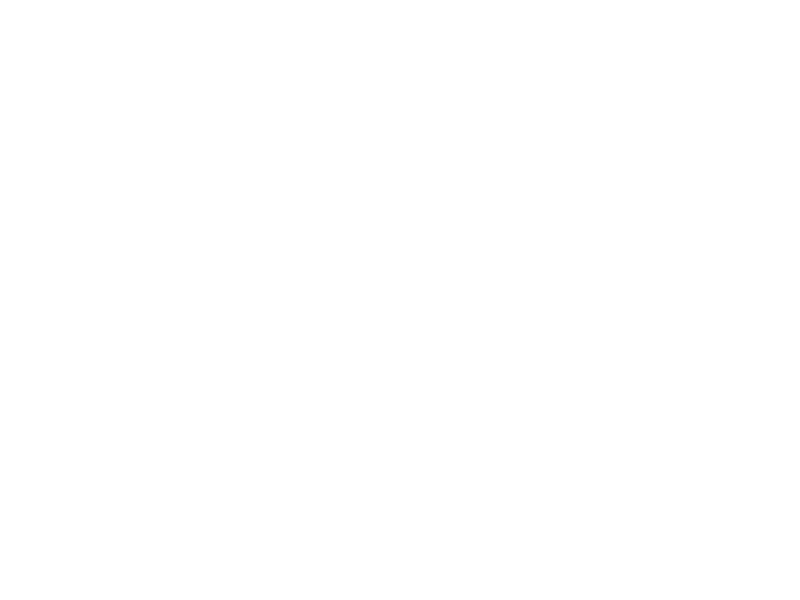

<IPython.core.display.Javascript object>


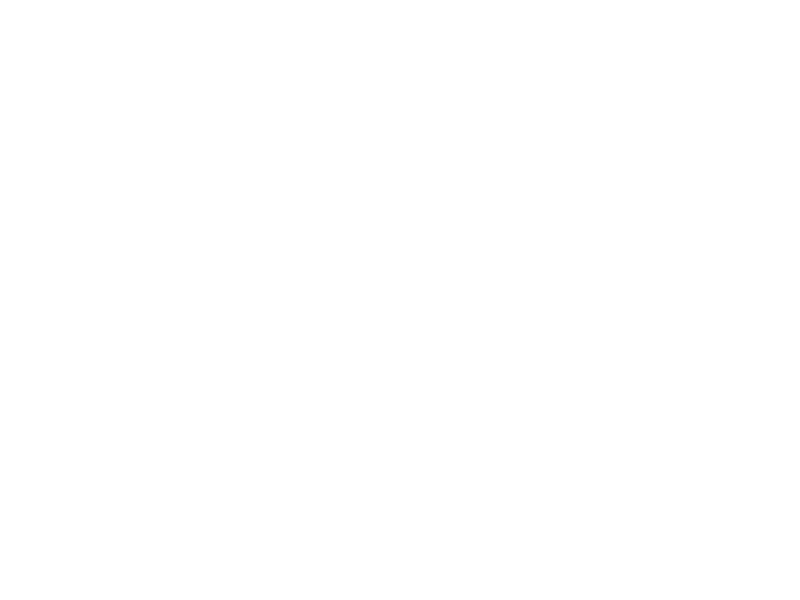

C:\Users\steph\.virtualenvs\POLAR-background-prediction-cyL85rzf\lib\site-packages\plotly\matplotlylib\renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



<IPython.core.display.Javascript object>


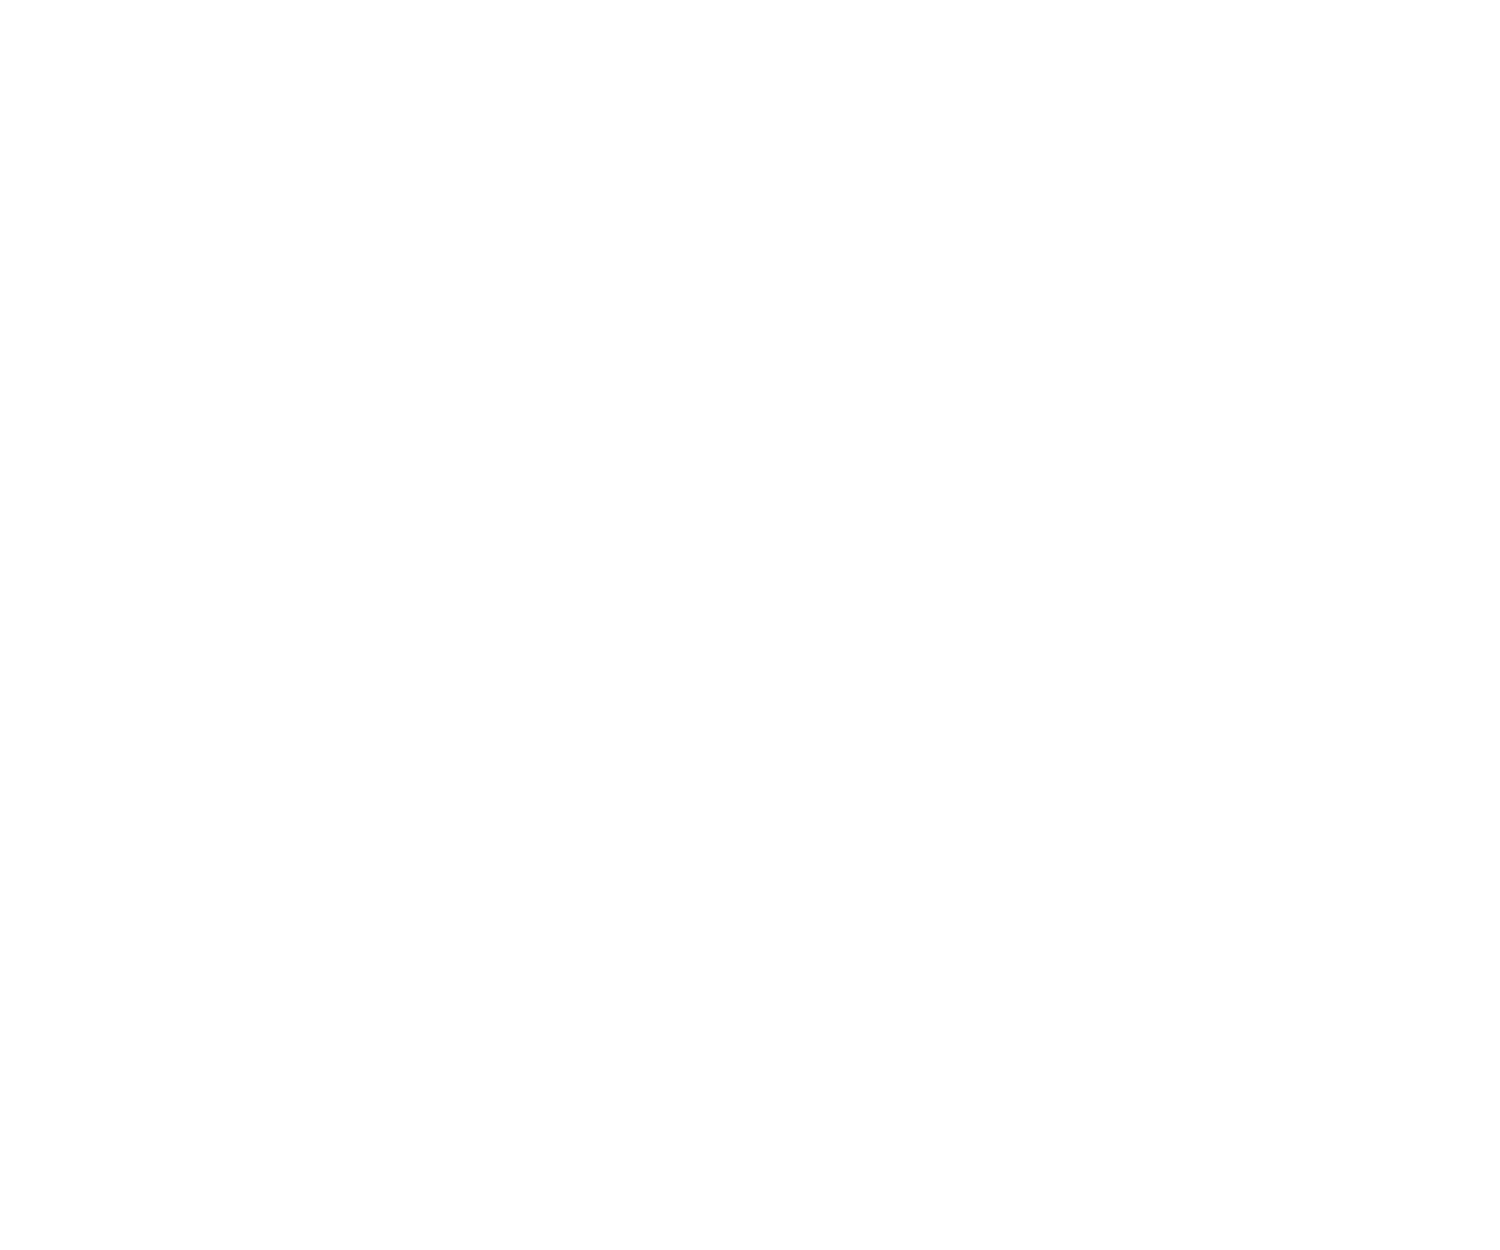

IndexError: list index out of range

In [32]:
import wandb
from wandb.sklearn import plot_learning_curve

%matplotlib notebook

model = pipe
model_params = model.get_params()

# Wandb:
wandb.init(project='POLAR-background-prediction', config=model_params)
wandb.config.update({"val_size": 0.2,
                     "test_size": 0.2,
                     "val_len": X_val.shape[0],
                     "test_len": X_test.shape[0],
                     "train_len": X_train.shape[0],
                     "random_state": 42,
                     "shuffle_data": True})

# plot_learning_curve(model, X_train, y_train)

plt.plot(fitted_mlp.loss_curve_)
wandb.log({"Training loss per epoch": plt})

plot_pred(X, y, pred_X, show=False, title=None)
wandb.log({"Prediction Rate 0 on whole dataset": plt})

plot_pull(X, y, pred_X, show=False, title=None)
wandb.log({"Pull plot": plt})

plot(tmp[mask].to_frame("rate[0]")/new_std, 0, 1, transform=None, show=False, title=None)
wandb.log({"Rescaled Normalized Pull Histogram (Density)": plt})

wandb.finish()

## Linear regression using `fe_cosmic`, to predict just `rate[0]`

In [ ]:
result = stats.linregress(X_train["fe_cosmic"], y_train["rate[0]"])

print(f"Slope a: {result.slope}, Intercept b: {result.intercept},\nR^2: {result.rvalue**2}, p-value: {result.pvalue}")
print("\n"+f"std_a: {result.stderr}, std_b: {result.intercept_stderr}")

In [ ]:
pred_linregress = X_test["fe_cosmic"]*result.slope + result.intercept

### Visualization

Let's only look at `rate[0]`

In [ ]:
# argsort = np.argsort(X_val["unix_time"])[::-1]
# sorted_time_val = X_val["unix_time"][argsort]
# sorted_y_val_r0 = y_val.loc[:, "rate[0]"][argsort]
sorted_val_r0_linregress = pred_linregress[argsort]

plt.plot(sorted_time_val, sorted_y_val_r0, '-g', linewidth=0.1)
plt.plot(sorted_time_val, sorted_val_r0_linregress, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]")
plt.show()

In [ ]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1500), (2000, 2500),
                                   (10000, 10500), (12000, 12500)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0_linregress[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

In [ ]:
low_n = 1000
high_n = 1500
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for i, (low_n, high_n) in enumerate([(1000, 1200), (2000, 2200),
                                   (10000, 10200), (12000, 12200)]):
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_y_val_r0[low_n:high_n], '-g', linewidth=0.5)
    axs[i//2, i%2].plot(sorted_time_val[low_n:high_n], sorted_val_r0_linregress[low_n:high_n], '-r', linewidth=0.5)
    axs[i//2, i%2].set_xlabel("Quantized Tunix [s]")
    axs[i//2, i%2].set_ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
    axs[i//2, i%2].set_title(f"Light curve Rate[0]: l={low_n}, h={high_n}")
plt.show()

**TODO: measure the loss using linear regression instead of multi-layer perceptron**

In [ ]:
# np.sqrt(fitted_mlp.loss_), np.std(sorted_y_val_r0)

### Residual plot
**Warning: we're gonna use the whole dataset, careful about data leakage**

In [ ]:
# predict using the whole X (fe_cosmic).. just to observe the residuals
pred_X = X["fe_cosmic"]*result.slope + result.intercept

In [ ]:
plt.plot(X["unix_time"], y.loc[:, "rate[0]"], '-g', linewidth=0.1)
plt.plot(X["unix_time"], pred_X, '-r', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate[0] [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve of Rate[0]: Prediction using whole dataset")
plt.show()

In [ ]:
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.03
rect_residuals = [left, bottom, width, height]
rect_histy = [left + width + spacing, bottom, 0.2, height]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_axes(rect_residuals)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

ax.plot(X["unix_time"], y.loc[:, "rate[0]"]-pred_X, '-r', linewidth=0.1)
ax.set_xlabel("Quantized Tunix [s]")
ax.set_ylabel("Residual for Rate[0]")  # Nb. photons per second (averaged over each bin)
ax.set_title("Residual plot for Rate[0]")



ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.set_title("Histogram")
ax_histy.set_xlabel("Count")


_ = ax_histy.hist(y.loc[:, "rate[0]"]-pred_X, bins=100, orientation='horizontal', alpha=0.5, zorder=np.inf)


plt.show()

**TODO: try compare via evaluation measures with NN**